Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.


# Distributed Training with a Large Image Dataset

_**Pointers for Optimizing Performance**_



## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data Preparation](#Data-Preparation)
1. [Bootstrapping Distributed Training](#Bootstrapping-Distributed-Training)
1. [Linear Scaling](#Linear-Scaling)
1. [Low-Priority Compute](#Low-Priority-Compute)
1. [Data Larger Than Disk](#Data-Larger-Than-Disk)
1. [Additional Pointers](#Additional-Pointers)

## Introduction

This notebook shows how to do distributed training on a large image dataset. Models are trained on all the images in the [MS COCO (Microsoft Common Objects in Context)](https://cocodataset.org/#home) dataset.

When training on larger data, there are some challenges that you may face. This notebooks aims to explore and discuss these challenges, as well give you some tips and tricks for working with larger data.

## Setup

Let's import some dependencies we'll need:

In [ ]:
import os
import tempfile

import matplotlib.pyplot as plt
import pandas as pd
from azureml.core import Dataset, Experiment, Workspace
from helper import create_compute_cluster, download_and_unzip_file, \
    get_az_storage_cli_auth_param, register_jsonl_dataset_from_coco_metadata, \
    wait_for_runs_to_complete
from launch_run import launch_run

Let's initialize the workspace, experiment, and datastore.

Make sure you have the run [configuration notebook](https://github.com/Azure/azureml-examples/blob/main/python-sdk/experimental/automl-model-testing/configuration.ipynb) to create a workspace and save its corresponding config file before running this notebook.

In [2]:
# initialize the workspace
workspace = Workspace.from_config()

# choose a name for experiment
experiment_name = "mscoco-distributed-training"

# initialize the experiment
experiment = Experiment(workspace, experiment_name)

# get a reference to the default datastore
datastore = workspace.get_default_datastore()

output = {}
output["Subscription ID"] = workspace.subscription_id
output["Workspace"] = workspace.name
output["Resource Group"] = workspace.resource_group
output["Location"] = workspace.location
output["Experiment Name"] = experiment.name
pd.set_option("display.max_colwidth", -1)
outputDf = pd.DataFrame(data=output, index=[""])
outputDf.T

,
Subscription ID,381b38e9-9840-4719-a5a0-61d9585e1e91
Workspace,daholstewseus
Resource Group,daholsterg
Location,eastus
Experiment Name,mscoco-distributed-training


## Data Preparation

### MS COCO Dataset

We'll train models on the [MS COCO (Microsoft Common Objects in Context)](https://cocodataset.org/#home) dataset, one of the largest publicly available image datasets.

We'll build a simple classification model to detect whether or not an image includes any people. Overall, the training set has ~ 118k images. Of these, ~ 64k (54%) contain at least one person, and ~ 54k (46%) contain no people.

We need to prepare the data to use in our experiments. In this section, we will:
1. Download the MS COCO images and metadata.
1. Upload the images to the workspace's default datastore.
1. Parse the metadata to produce a JSONL dataset containing the name of each image and whether or not that image contains >= 1 person.

Download and unzip the images and metadata:

In [3]:
# Set the destination directory where the ZIP files should be downloaded and extracted.
# Note: the artifacts are just under 40 GB in size.
destination_directory = tempfile.gettempdir()

download_and_unzip_file('http://images.cocodataset.org/annotations/annotations_trainval2017.zip', destination_directory)
download_and_unzip_file('http://images.cocodataset.org/zips/val2017.zip', destination_directory)
download_and_unzip_file('http://images.cocodataset.org/zips/train2017.zip', destination_directory)

Next, we need to upload the files to the workspace.

Upload the images in the validation set:

In [ ]:
!az storage fs directory upload --source {os.path.join(destination_directory, 'val2017')} -f {datastore.container_name} --account-name {datastore.account_name} {get_az_storage_cli_auth_param(datastore)} -d /coco/ --recursive

Upload the images in the training set:

In [ ]:
!az storage fs directory upload --source {os.path.join(destination_directory, 'train2017')} -f {datastore.container_name} --account-name {datastore.account_name} {get_az_storage_cli_auth_param(datastore)} -d /coco/ --recursive

Parse the MS COCO metadata artifacts to produce and register Azure Datasets for the training and validation data:

In [6]:
register_jsonl_dataset_from_coco_metadata(
    workspace=workspace,
    coco_metadata_file_path=os.path.join(destination_directory, 'annotations', 'instances_val2017.json'),
    output_jsonl_file_path=os.path.join(destination_directory, 'coco_valid_jsonl', 'coco_valid.jsonl'),
    dataset_name='coco_valid',
    dataset_path_in_datastore='coco/val2017')

register_jsonl_dataset_from_coco_metadata(
    workspace=workspace,
    coco_metadata_file_path=os.path.join(destination_directory, 'annotations', 'instances_train2017.json'),
    output_jsonl_file_path=os.path.join(destination_directory, 'coco_train_jsonl', 'coco_train.jsonl'),
    dataset_name='coco_train',
    dataset_path_in_datastore='coco/train2017')

We now have two datasets registered in the workspace, `coco_valid` and `coco_train`:

In [7]:
Dataset.get_by_name(workspace, 'coco_valid').take(5).to_pandas_dataframe()

,image_url,contains_person
0,workspaceblobstore/coco/valid/000000397133.jpg,True
1,workspaceblobstore/coco/valid/000000037777.jpg,False
2,workspaceblobstore/coco/valid/000000252219.jpg,True
3,workspaceblobstore/coco/valid/000000087038.jpg,True
4,workspaceblobstore/coco/valid/000000174482.jpg,False


In [8]:
Dataset.get_by_name(workspace, 'coco_train').take(5).to_pandas_dataframe()

,image_url,contains_person
0,workspaceblobstore/coco/train/000000391895.jpg,True
1,workspaceblobstore/coco/train/000000522418.jpg,True
2,workspaceblobstore/coco/train/000000184613.jpg,True
3,workspaceblobstore/coco/train/000000318219.jpg,True
4,workspaceblobstore/coco/train/000000554625.jpg,True


## Linear Scaling

Ideally, as the number of VMs training a given model increases, the time to train that model should decrease linearly. For instance, if training a model using one VM takes 100 seconds, then training that same model using two VMs should ideally take 50 seconds. Using four VMs should ideally take 25 seconds, and so on. Also ideally, model quality / accuracy should not be affected by the number of VMs used.

#### InfiniBand

To attain linear scaling, one important step can be to use InfiniBand. InfiniBand enables low-latency, GPU-to-GPU communication across nodes in a cluster. InfiniBand requires specialized hardware to operate. Only some VM SKUs on Azure contain this required hardware. Typically, the VM SKUs containing an 'R' in their name have the required InfiniBand hardware, versus those without the 'R' do not. ('R' is a reference to RDMA, which stands for "remote direct memory access.")

You can view the full list of InfiniBand-enabled machine SKUs [here](https://docs.microsoft.com/en-us/azure/virtual-machines/sizes-hpc#rdma-capable-instances). On that page, for instance, you'll see the VM SKU `STANDARD_NC24S_V3` is not InfiniBand-enabled, but the SKU `STANDARD_NC24RS_V3` is. The only difference in the names is that added 'R'. Aside from the InfiniBand capabilities, the specs between these two SKUs are largely the same &ndash; they have both 24 cores, 448 GB RAM, 4 NVIDIA Tesla V100 GPUS, etc.  (Caveat: the older-generation machine SKU `STANDARD_NC24R` is a notable exception to the rule that SKU names containing 'R' are InfiniBand-enabled. The SKU is RDMA-enabled, but it does not have SR-IOV hardware required for InfiniBand.)

####  InfiniBand Experiment

Let's do an experiment to see how InfiniBand affects the training time as we scale up the number of nodes.

Let's create two compute clusters: One `STANDARD_NC24RS_V3` and one `STANDARD_NC24S_V3`. As discussed above, these SKUs essentially only differ in whether or not they are InfiniBand-enabled. Also, note that these are both SKUs with later-generation hardware. You may observe better and more consistent performance on these SKUs than on SKUs with earlier-generation hardware.

In [ ]:
infiniband_cluster = create_compute_cluster(
    name='nc24rsv3',
    sku='STANDARD_NC24RS_V3',
    workspace=workspace)

standard_cluster = create_compute_cluster(
    name='nc24sv3',
    sku='STANDARD_NC24S_V3',
    workspace=workspace)

We'll kick off several runs, each training the model on the whole dataset for one epoch:

In [ ]:
infiniband_run_4_nodes = launch_run(experiment=experiment, cluster=infiniband_cluster, node_count=4)
infiniband_run_4_nodes.wait_for_completion()

In [ ]:
infiniband_run_2_nodes = launch_run(experiment=experiment, cluster=infiniband_cluster, node_count=2)
infiniband_run_2_nodes.wait_for_completion()

In [ ]:
infiniband_run_1_node = launch_run(experiment=experiment, cluster=infiniband_cluster, node_count=1)
infiniband_run_1_node.wait_for_completion()

In [ ]:
standard_run_4_nodes = launch_run(experiment=experiment, cluster=standard_cluster, node_count=4)
standard_run_4_nodes.wait_for_completion()

In [ ]:
standard_run_2_nodes = launch_run(experiment=experiment, cluster=standard_cluster, node_count=2)
standard_run_2_nodes.wait_for_completion()

In [ ]:
standard_run_1_node = launch_run(experiment=experiment, cluster=standard_cluster, node_count=1)
standard_run_1_node.wait_for_completion()

Let's plot the real and ideal training times of the runs on InfiniBand-enabled cluster:

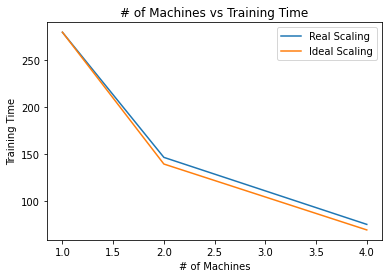

In [46]:
infiniband_run_4_nodes_run_time = infiniband_run_4_nodes.get_metrics(name='epoch_train_time')['epoch_train_time']
infiniband_run_2_nodes_run_time = infiniband_run_2_nodes.get_metrics(name='epoch_train_time')['epoch_train_time']
infiniband_run_1_node_run_time = infiniband_run_1_node.get_metrics(name='epoch_train_time')['epoch_train_time']

num_machines = [1, 2, 4]
real_training_times = [infiniband_run_1_node_run_time, infiniband_run_2_nodes_run_time, infiniband_run_4_nodes_run_time]
ideal_training_times = [infiniband_run_1_node_run_time, infiniband_run_1_node_run_time / 2, infiniband_run_1_node_run_time / 4]
plt.plot(num_machines, real_training_times, label='Real Scaling')
plt.plot(num_machines, ideal_training_times, label='Ideal Scaling')
plt.legend()
plt.title('# of Machines vs Training Time')
plt.xlabel('# of Machines')
plt.ylabel('Training Time')
plt.show()

Plot the same for the runs on the standard cluster:

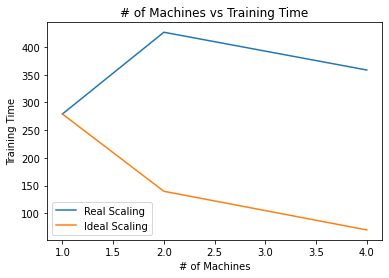

In [48]:
standard_run_4_nodes_run_time = standard_run_4_nodes.get_metrics(name='epoch_train_time')['epoch_train_time']
standard_run_2_nodes_run_time = standard_run_2_nodes.get_metrics(name='epoch_train_time')['epoch_train_time']
standard_run_1_node_run_time = standard_run_1_node.get_metrics(name='epoch_train_time')['epoch_train_time']

num_machines = [1, 2, 4]
real_training_times = [standard_run_1_node_run_time, standard_run_2_nodes_run_time, standard_run_4_nodes_run_time]
ideal_training_times = [standard_run_1_node_run_time, standard_run_1_node_run_time / 2, standard_run_1_node_run_time / 4]
plt.plot(num_machines, real_training_times, label='Real Scaling')
plt.plot(num_machines, ideal_training_times, label='Ideal Scaling')
plt.legend()
plt.title('# of Machines vs Training Time')
plt.xlabel('# of Machines')
plt.ylabel('Training Time')
plt.show()

While InifiBand helps attain linear scaling, there are of course many other reasons you may get less-than-linear scale. Many of them are addressed in the [Additional Pointers](#Additional-Pointers) section near the end of this document.

#### Scaling the Learning Rate

A quick note on maintaining model quality / accuracy as you scale up the number of training nodes: as you scale up the number of nodes, you may need to scale up the learning rate. In the training script for this notebook, we have

```python
SCALED_LEARNING_RATE = LEARNING_RATE * WORLD_SIZE
```
that scales the learning rate linearly with the number of the VMs. More details on scaling the learning rate / the reasoning behind it can be viewed in [this paper](https://arxiv.org/abs/1706.02677v1). There are many more resources and strategies for adjusting the learning rate as you scale available on the web.

#### Accuracy Experiment

Let's kick off a distributed run and a single-box run, and then sanity check that the training curves look similar. For the sake of speeding up the experiment a little, let's train on a subsample of the first 50k images (out of roughly ~ 118k images) in the train set.

In [ ]:
run_with_4_nodes = launch_run(
    experiment=experiment,
    cluster=infiniband_cluster,
    node_count=4,
    num_epochs=5,
    subsample_first_n_images=50000)

run_with_4_nodes.wait_for_completion()

In [ ]:
run_with_1_node = launch_run(
    experiment=experiment,
    cluster=standard_cluster,
    node_count=1,
    num_epochs=5,
    subsample_first_n_images=50000)

run_with_1_node.wait_for_completion()

Plotting the validation accuracy after each epoch:

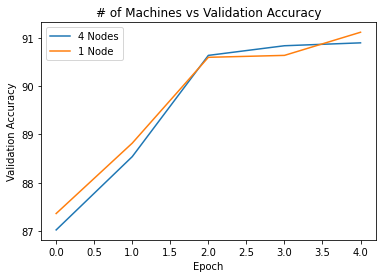

In [59]:
validation_accuracies_with_4_nodes = run_with_4_nodes.get_metrics(name='validation_accuracy')['validation_accuracy']
validation_accuracies_with_1_node = run_with_1_node.get_metrics(name='validation_accuracy')['validation_accuracy']

epochs = range(5)
plt.plot(epochs, validation_accuracies_with_4_nodes, label='4 Nodes')
plt.plot(epochs, validation_accuracies_with_1_node, label='1 Node')
plt.legend()
plt.title('# of Machines vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()

## Low-Priority Compute

Using [low-priority nodes](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-manage-optimize-cost#low-pri-vm) in a compute cluster can pose additional challenges. In this section, we'll focus on describing and mitigating one such challenge.

When a job is using low-priority nodes that get pre-empted, that job of course stops running, and it waits for compute to become available again. Once low-priority nodes become available, the run restarts "from scratch." In other words, previous state on the compute is lost, and the Python script that was submitted to be executed by the run is re-invoked fresh on all compute nodes. This means that, without special handling, every time a DNN training run is pre-empted and then restarts, the run will start the training from epoch 0 again. For this reason, we need some special handling in the script to save state between pre-emptions, so previous work can be reused after restarts.

We handle this is in the training script by checkpointing the latest model after each epoch:

```python
for epoch in range(...):
    ...
    train_epoch(...)

    if RANK == 0:
        save_checkpoint(model, optimizer, epoch)
    ...
```
Note we only need to save the model on a single worker (arbitrarily selected worker with rank 0).

Save checkpoint is implemented as:
```python
def save_checkpoint(model, optimizer, epoch):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, CHECKPOINT_MODEL_PATH)
    ...
```

This code saves a copy of of the relevant information to `CHECKPOINT_MODEL_PATH`. This info includes the latest model weights and optimizer state, as long as the latest epoch that has been trained. Saving to `CHECKPOINT_MODEL_PATH` triggers an automatic upload of the model to blob storage. This is because when we launched the script run above, we passed an `OutputFileDatasetConfig`:

```python
output_dataset_config = OutputFileDatasetConfig('model_checkpoints',
                                                destination=...,
                                                source='model_checkpoints/')
...
ScriptRunConfig(...,
                script='training_script_classification.py',
                arguments=[output_dataset_config], compute_target=cluster,
                ...,
                distributed_job_config=distributed_config)
```

Under the hood, this means that whenever a file is written to the `model_checkpoints` directory on the compute, it will automatically be uploaded to the `destination` parameter in the blob. This also means that any file available in the blob storage directory is also available to compute. In other words, the blob folder represented by `destination` is mounted on disk to the `model_checkpoints` directory. Also, note that if the `destination` parameter is blank, the default destination in blob storage is `/dataset/{run_id}/model_checkpoints/`. See the documentation on [OutputFileDatasetConfig](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.output_dataset_config.outputfiledatasetconfig?view=azure-ml-py) for more info.

Finally, at the start of our training script, we have:

```python
if checkpoint_file_exists:
    ...
    model, optimizer, starting_epoch = load_checkpoint()
    starting_epoch += 1
else:
    model = init_model()
    optimizer = init_optimizer(model)
    starting_epoch = 0
```

This means that, when the script starts, by default, it will check to see if a checkpoint already exists in storage. If a saved checkpoint exists, the script will load the saved state, and continue from there. Otherwise, the script will start training a new model from scratch.

#### Experiment

Let's try an experiment. Perhaps unlike linear scalability, pre-emption isn't something that we can demonstrate precisely, because pre-emption of a low pri node can't be forced. (Azure forces or doesn't force pre-emption based on data-center-wide availability of the hardware SKU and other factors.) However, perhaps we can simulate pre-emption. We'll start a few runs.

First, do a run for only 2 nodes on high-priority compute.

In [ ]:
nc6sv3_cluster = create_compute_cluster(
    name='nc6sv3',
    sku='Standard_NC6S_V3',
    workspace=workspace
)

run1 = launch_run(
    experiment=experiment,
    cluster=nc6sv3_cluster,
    subsample_first_n_images=5000,
    num_epochs=2)

run1.wait_for_completion()

Checking the relevant metrics:

In [63]:
run1.get_metrics(name='training_epoch')

{'training_epoch': [0, 1]}

We can see that the run only trained epochs 0 and 1.

During the course of its run, the run should have saved a checkpoint in the `/dataset/{run1.id}/model_checkpoints/` directory in storage. So, with our script, if we started another run (say run 2), but we overrode the checkpoint path in storage for this new run from its default of `/dataset/{run2.id}/model_checkpoints/` to `/dataset/{run1.id}/model_checkpoints/`, run2 should continue training the model from where the first run left off. Let's see if that's the case.

Kicking off run2:

In [ ]:
run2 = launch_run(
    experiment=experiment,
    cluster=nc6sv3_cluster,
    subsample_first_n_images=5000,
    num_epochs=4,
    output_dataset_storage_path=f'/dataset/{run1.id}/model_checkpoints/')

run2.wait_for_completion()

Checking the metrics:

In [67]:
run2.get_metrics(name='training_epoch')

{'training_epoch': [2, 3]}

We see that this is indeed the case. Only the second 2 epochs were trained.

#### Handling Metrics

When a pre-empted job is resumed, metrics from previous runs are still present. This is something to keep in mind.

You probably also want to ensure all metrics are flushed (a.k.a. sent from local compute to the metrics servers) around the same time that the model checkpoint is saved. This reduces the likelihood of a race condition where the checkpoint is saved and the run is pre-empted, but recent metrics for the run haven't yet been flushed and hence are lost.

In the training script, you can see that we flush metrics right before saving the checkpoint:

```python
run.flush()
save_checkpoint(model, optimizer, epoch)
```

## Data Larger Than Disk

This section aims to explore how to train on data that is too large to fit on disk. Often times, for image workflows, the images in a dataset are all downloaded to disk up front. Then during training, images are loaded from disk into memory each epoch.

When the data is too large to be downloaded to disk, one possible way to handle this is to stream images from blob storage into memory each epoch.

#### Experiment

Let's kick off two runs: one that downloads all images to disk up front, and one that streams the images from storage during training.

In [ ]:
stream_images_run = launch_run(
    experiment=experiment,
    cluster=nc6sv3_cluster,
    download_images=False,
    subsample_first_n_images=10000)

stream_images_run.wait_for_completion()

In [ ]:
download_images_run = launch_run(
    experiment=experiment, 
    cluster=nc6sv3_cluster, 
    download_images=True,
    subsample_first_n_images=10000)

download_images_run.wait_for_completion()

Note the `download_images` parameter above. By default, this parameter is `False`. This means that all runs kicked off by this notebook previously have been streaming images from storage.

Let's briefly discuss how `download_images` is treated in the training script. First, if `download_data` is `True`, the images are all downloaded up front.

```python
if args.download_images:
    ...
    dataset.download('image_url', TRAIN_IMAGE_DOWNLOAD_DIR, overwrite=True)
    valid_dataset.download('image_url', VALID_IMAGE_DOWNLOAD_DIR, overwrite=True)
```

Then during training, images are either loaded from disk or from storage:

```python
class Dataset(torch.utils.data.Dataset):

    ...
    
    def __getitem__(self, index):        
        if self._download_images:
            with open(f"{self._images_dir}/...", 'rb') as f:
                image_bytes = f.read()
        else:
            blob_name = str(...)
            ...
            stream = blob_client.download_blob()
            image_bytes = stream.readall()

```

Plotting the training time for both runs:

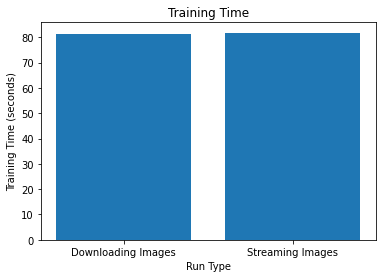

In [71]:
stream_images_epoch_train_time = stream_images_run.get_metrics(name='epoch_train_time')['epoch_train_time']
download_images_run_epoch_train_time = download_images_run.get_metrics(name='epoch_train_time')['epoch_train_time']

plt.bar(['Downloading Images', 'Streaming Images'], [download_images_run_epoch_train_time, stream_images_epoch_train_time])
plt.title('Training Time')
plt.xlabel('Run Type')
plt.ylabel('Training Time (seconds)')
plt.show()

Training time in both runs should be roughly the same.

#### Caveats

With this approach, it is strongly recommended to make sure that the storage account you're streaming the images from is in the same data center as the compute. Otherwise, both [bandwidth costs](https://azure.microsoft.com/en-us/pricing/details/bandwidth/) and network latency may become noticeable.

Also, downloading and streaming may only be similar in speed in scenarios where GPU utilization is high. When GPU is the bottleneck in the overall training training run, the extra bit of latency and CPU incurred in fetching the images from storage instead of disk may be small enough not to impact overall training time. There are other scenarios, however, where CPU is the bottleneck. This may be the case for jobs that train a small model on newer GPUs. One question that comes to mind is, for scenarios that train small models, will very large data (larger than can fit on disk) be needed? If not, the data can be downloaded. If so, in workflows where CPU utilization hovers near 100%, the streaming approach will likely increase total training time. In one such workflow, it was observed that total training time increased by ~ 30%. Fetching blobs from storage can require additional CPU in workflows that are already CPU-constrained. One thing to note is that, in many image workflows, most of the CPU time can be spent on image decoding. One idea to speed up such workflows is leveraging the GPU to decode images. NVIDIA has written the [NVIDIA DALI](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/) library for batch GPU image decoding that may be useful in these cases.

## Additional Pointers

Below are some additional pointers for training on larger data.

#### OpenCV

If using OpenCV for image decoding, it's important to limit the number of parallel threads the library can use. In the training script, we call
```python
cv2.setNumThreads(0)
```
Without limiting the degree of parallelism, when multiple training processes are kicked off on the same node, there may be a library issue that drives CPU utilization to hover near 100% and increases overall training time significantly.

#### Use the Latest Azure Storage SDK

When you call datastore.blob_service,

In [72]:
type(datastore.blob_service)

azureml._vendor.azure_storage.blob.blockblobservice.BlockBlobService

an object of type `azureml._vendor.azure_storage.blob.blockblobservice.BlockBlobService` is returned. This a vendored version of a legacy API of the Azure storage SDK. This may cause deadlocks and other performance problems. For that reason, in the training script, we use the latest Azure Storage SDK:

```python
from azure.storage.blob import BlobServiceClient
blob_service_client = BlobServiceClient(
            account_url=datastore.blob_service.primary_endpoint,
            credential=datastore.account_key or datastore.sas_token)
```

#### Custom Dockerfile to Use Latest Libraries

You can see that we're using our own Dockerfile to kick off the training script. This is because, right now, the existing default base images use older versions of some libraries (MPI, UCX) that can result in segmentation faults during distributed training. The referenced Dockerfile uses upgraded versions of these libraries.

#### Number of PyTorch Data Loader Workers

We recommend starting one process for each GPU on the machine. In the script runs launched by this notebook, the following aims to do this:

```python
PyTorchConfiguration(process_count=num_gpus * node_count, node_count=node_count)
```

Within each process, limit the number of PyTorch data loader workers:

```python
num_workers = os.cpu_count() // LOCAL_SIZE
train_data_loader = DataLoader(train_dataset, ..., num_workers=num_workers, ...)

```

This ensures that the total number of PyTorch data loader workers is equal to the total number of CPUs on the machine. This both ensures good CPU utilization if required and also limits the total number of batches prefetched into memory.

#### Can an input dataset be used instead of streaming images in Python?

In the section on low priority compute, you'll recall that we mounted a directory in blob storage to a directory on local compute. If this is possible, could we also mount the input dataset (that lives in blob storage) to a directory on disk and then access the training images through the file system API? In some experiments, it was observed that this approach may be slower than streaming images directly in Python. Caveat: the investigation of the root cause in these experiments is ongoing. This is not an official result, but rather just a comment aimed at potentially saving you time.

#### Logging Metrics and Uploading Files From a Single Node

You may want to log metrics and upload files only from a single node. This reduces metrics noise when looking at dashboards and avoids unnecessary uploads to storage. Re: metrics noise, as an example, let's consider the metric `validation_accuracy` logged after each epoch in the training script. Let's say the accuracy after the first two epochs are 85% and 90%. If the metric is logged from 2 nodes, the result of `run.get_metrics()` will contain `[85, 85, 90, 90]`. If the metrics are logged from a single node, the result of the same call will instead contain `[85, 90]`. Similar repetitions will appear visually on charts and dashboards in the portal.